# Image classification from scratch

**Author:** fchollet  
**Date created:** 2020/04/27  
**Last modified:** 2023/11/09  
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.

In [27]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [28]:
if not os.path.exists("kagglecatsanddogs_5340.zip"):
    !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
else:
    print("Dataset zip already exists. Skipping download.")

Dataset zip already exists. Skipping download.


In [29]:
if not os.path.exists("PetImages"):
    !unzip -q kagglecatsanddogs_5340.zip
    print("Unzipped dataset.")
else:
    print("PetImages folder already exists. Skipping unzip.")
!ls

PetImages folder already exists. Skipping unzip.
CDLA-Permissive-2.0.pdf    kagglecatsanddogs_5340.zip
PetImages                  readme[1].txt
app.py                     requirements.txt
cats_dogs_model.keras      save_at_1.keras
image_classification.ipynb


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each subfolder contains image files for each category.

In [30]:
!ls PetImages

Cat Dog


## Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [31]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


## Generate a Dataset

In [32]:
image_size = (180, 180)
batch_size = 32 # Reduced from 128 to 32 for CPU speed

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset.

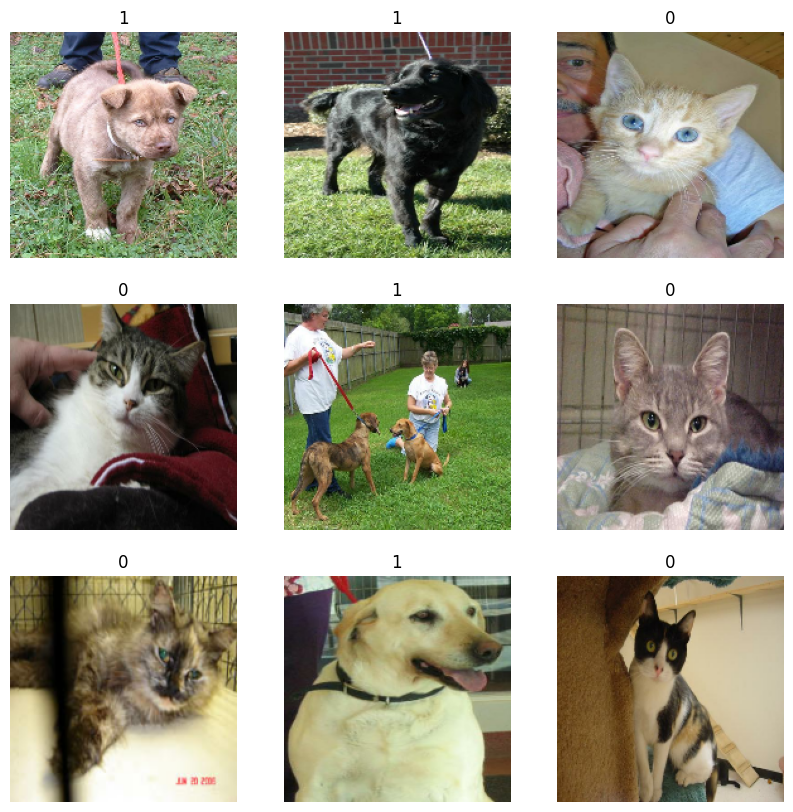

In [33]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [34]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Let's visualize what the augmented samples look like, by applying `data_augmentation` repeatedly to the first few images in the dataset:

2026-02-12 13:00:43.325070: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


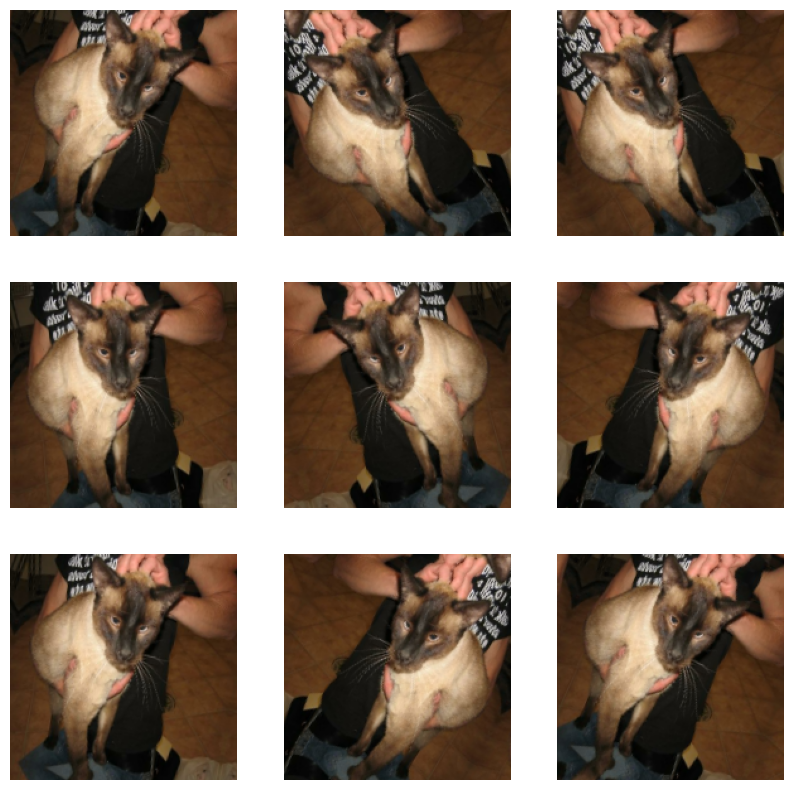

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

### Two options to preprocess the data

There are two ways you could be using the data_augmentation preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of augmented images, like this:

```python
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
```

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [36]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

- We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
- We include a Dropout layer before the final classification layer.

In [37]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Image augmentation block (This makes it slower on CPU, but helps accuracy)
    # x = data_augmentation(inputs)  
    # To speed up training heavily, we can skip augmentation inside the model
    # and just rely on the pre-processing map we did earlier, or disable it.
    
    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Simple Block 1
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Simple Block 2
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

## Train the model

In [38]:
epochs = 2

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Train the model
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/2


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


314/586 ━━━━━━━━━━━━━━━━━━━━ 1:31 338ms/step - acc: 0.5670 - loss: 0.7127

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


346/586 ━━━━━━━━━━━━━━━━━━━━ 1:20 337ms/step - acc: 0.5686 - loss: 0.7105

425/586 ━━━━━━━━━━━━━━━━━━━━ 54s 339ms/step - acc: 0.5721 - loss: 0.7057

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


432/586 ━━━━━━━━━━━━━━━━━━━━ 52s 339ms/step - acc: 0.5724 - loss: 0.7053

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


454/586 ━━━━━━━━━━━━━━━━━━━━ 45s 342ms/step - acc: 0.5734 - loss: 0.7041

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


460/586 ━━━━━━━━━━━━━━━━━━━━ 43s 342ms/step - acc: 0.5736 - loss: 0.7038

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - acc: 0.5781 - loss: 0.6981

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 ━━━━━━━━━━━━━━━━━━━━ 209s 354ms/step - acc: 0.5949 - loss: 0.6752 - val_acc: 0.5617 - val_loss: 0.6826
Epoch 2/2


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


320/586 ━━━━━━━━━━━━━━━━━━━━ 1:18 295ms/step - acc: 0.6288 - loss: 0.6421

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


351/586 ━━━━━━━━━━━━━━━━━━━━ 1:09 295ms/step - acc: 0.6287 - loss: 0.6419

428/586 ━━━━━━━━━━━━━━━━━━━━ 46s 295ms/step - acc: 0.6290 - loss: 0.6410

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


434/586 ━━━━━━━━━━━━━━━━━━━━ 44s 295ms/step - acc: 0.6291 - loss: 0.6410

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


447/586 ━━━━━━━━━━━━━━━━━━━━ 40s 294ms/step - acc: 0.6292 - loss: 0.6408

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


456/586 ━━━━━━━━━━━━━━━━━━━━ 38s 294ms/step - acc: 0.6292 - loss: 0.6407

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - acc: 0.6303 - loss: 0.6392

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 ━━━━━━━━━━━━━━━━━━━━ 182s 311ms/step - acc: 0.6348 - loss: 0.6316 - val_acc: 0.6064 - val_loss: 0.6124


We get to >90% validation accuracy after training for 25 epochs on the full dataset (in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
This image is 79.90% cat and 20.10% dog.


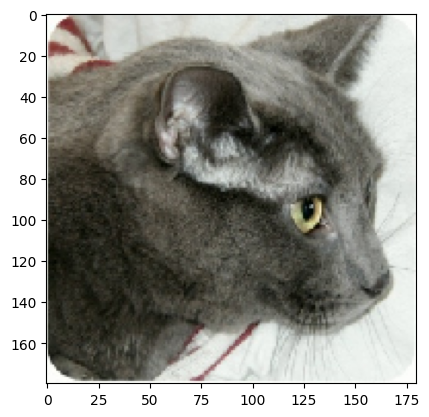

In [39]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [40]:
# Save the final model for the desktop app
model.save('cats_dogs_model.keras')
print("Model saved as 'cats_dogs_model.keras'")

Model saved as 'cats_dogs_model.keras'
